In [2]:
pip install xgboost

     |████████████████████████████████| 1.8 MB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('AEP_hourly.csv', index_col=[0], parse_dates=[0])

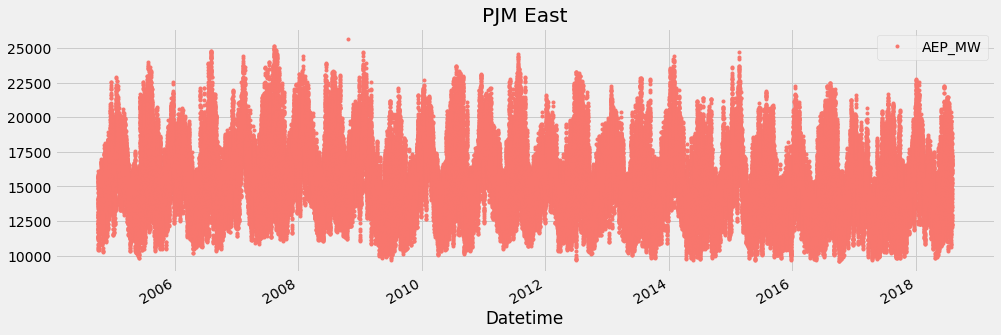

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [5]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


# Train Test Split

In [8]:
split_date = '01-Jan-2015'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()

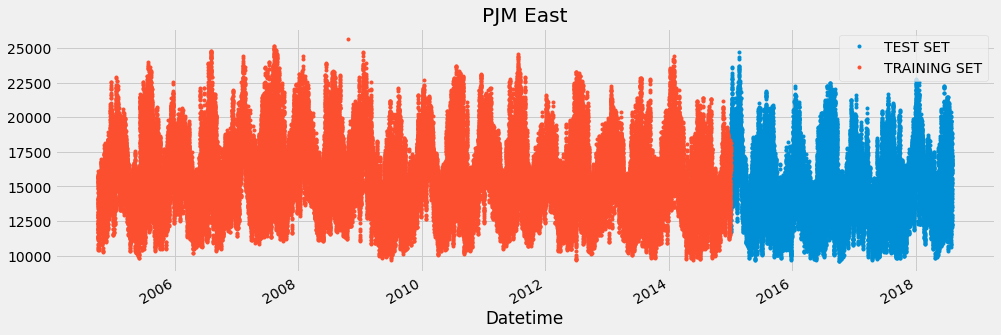

In [11]:
d = pjme_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create Time Series Features

In [12]:
def create_features(df1, label=None):
    """
    Creates time series features from datetime index
    """
    df1['date'] = df1.index
    df1['hour'] = df1['date'].dt.hour
    df1['dayofweek'] = df1['date'].dt.dayofweek
    df1['quarter'] = df1['date'].dt.quarter
    df1['month'] = df1['date'].dt.month
    df1['year'] = df1['date'].dt.year
    df1['dayofyear'] = df1['date'].dt.dayofyear
    df1['dayofmonth'] = df1['date'].dt.day
    df1['weekofyear'] = df1['date'].dt.weekofyear
    
    X = df1[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df1[label]
        return X, y
    return X

In [13]:
X_train, y_train = create_features(pjme_train, label='AEP_MW')
X_test, y_test = create_features(pjme_test, label='AEP_MW')

/var/folders/p8/br7xvzdn4rxcs2p_kxtfn_lh0000gn/T/ipykernel_11420/1592972874.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['weekofyear'] = df1['date'].dt.weekofyear


# Create XGBoost Model

In [14]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

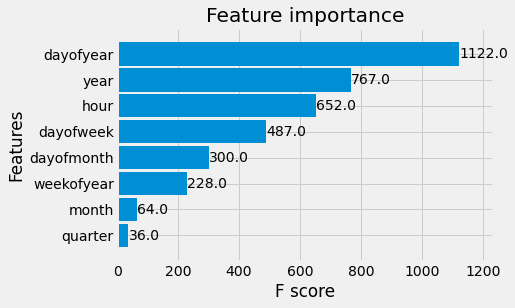

In [15]:
a = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [20]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

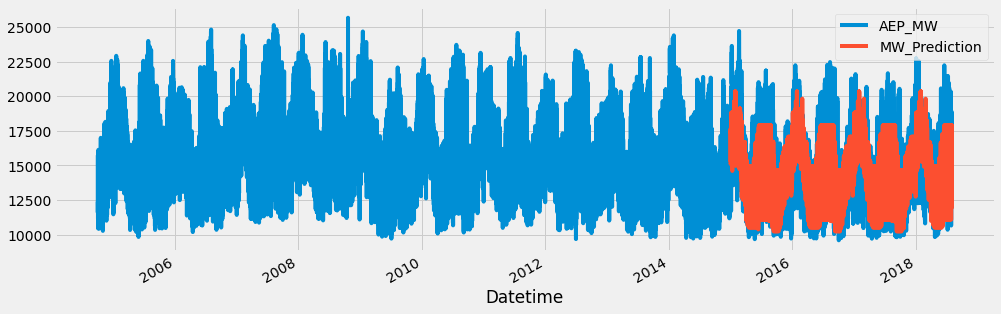

In [22]:
b = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at First Month Predictions

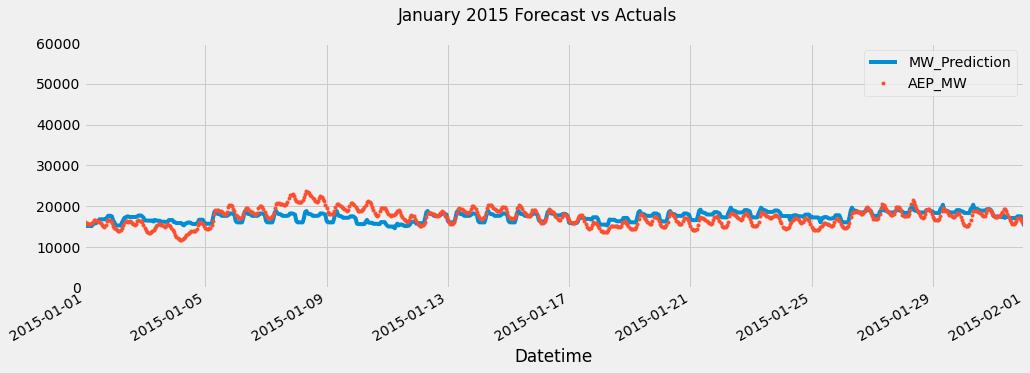

In [23]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

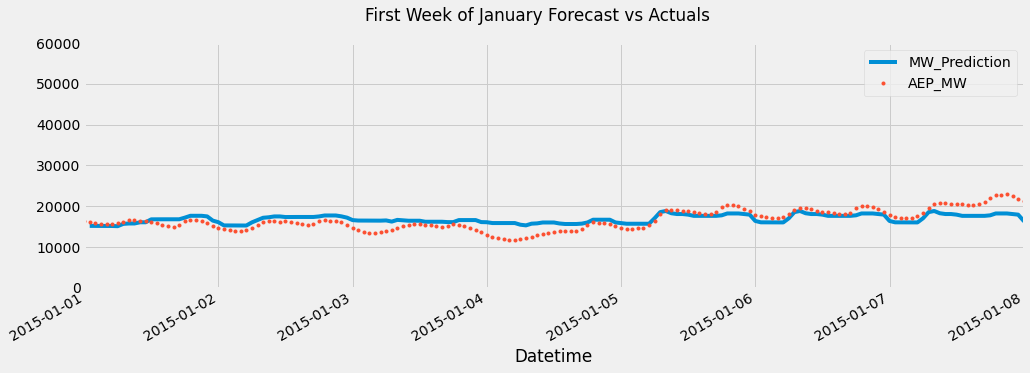

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

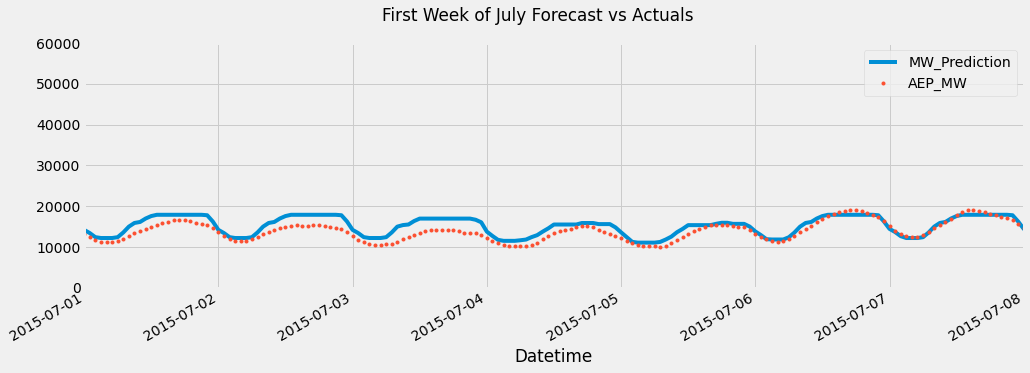

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics on Test Set

In [28]:
mean_squared_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2604129.5553274993

In [29]:
mean_absolute_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

1237.3640072963715

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.270429862369676

# Look at Worst and Best Predicted Days

In [32]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [33]:
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2017 1     22          12295.541667   16617.234375 -4321.693319  4321.693319
           21          12891.375000   16997.955078 -4106.580526  4106.580526
     2     23          13437.333333   17466.052734 -4028.720256  4028.720256
     1     23          14428.125000   18355.421875 -3927.295898  3927.295898
     2     24          13111.625000   17027.525391 -3915.900187  3915.900187
           22          13582.750000   17466.052734 -3883.303589  3883.303589
2018 1     22          14509.750000   18355.421875 -3845.670898  3845.670898
2015 12    25          11078.041667   14744.424805 -3666.382731  3666.382731
2017 1     25          14862.458333   18526.003906 -3663.545410  3663.545410
2016 7     4           12048.000000   15698.821289 -3650.821615  3650.821615

In [34]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 2     20          22047.041667   16496.251953  5550.789307  5550.789307
           19          22249.500000   16979.966797  5269.532389  5269.532389
2018 1     6           20847.833333   15837.413086  5010.420003  5010.420003
           7           19803.375000   15390.620117  4412.754720  4412.754720
2015 1     8           21873.333333   17497.107422  4376.226562  4376.226562
2017 1     22          12295.541667   16617.234375 -4321.693319  4321.693319
     12    28          19396.291667   15211.703125  4184.588582  4184.588582
2015 2     16          21129.791667   16984.783203  4145.009155  4145.009155
2017 1     21          12891.375000   16997.955078 -4106.580526  4106.580526
2018 1     2           20938.500000   16871.527344  4066.973470  4066.973470

In [35]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 11    8           14602.750000   14602.919922   -0.169474  203.321248
     10    28          12723.833333   12744.483398  -20.650431  214.592570
2018 6     23          14103.291667   14031.885742   71.405680  256.993490
     4     28          12237.583333   12252.085938  -14.502563  259.252157
2015 9     30          13556.583333   13707.728516 -151.145549  264.775920
2017 4     1           12569.208333   12430.785156  138.423665  267.845052
     11    16          14938.958333   14918.449219   20.509603  279.187012
2016 12    12          15836.333333   15871.387695  -35.054525  283.551107
     3     5           14801.166667   14795.866211    5.300618  290.299398
     12    2           15458.250000   15604.341797 -146.091756  291.837443

# Plotting some best/worst predicted days

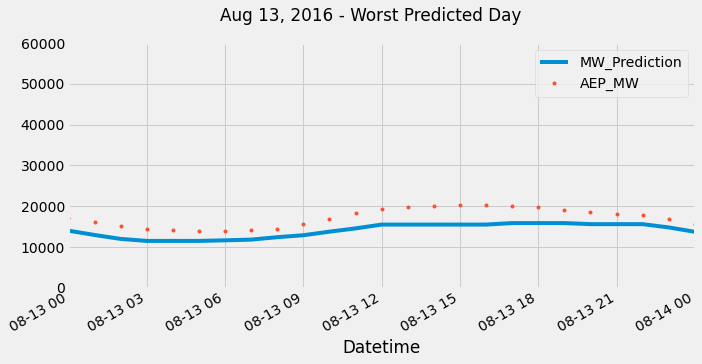

In [36]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

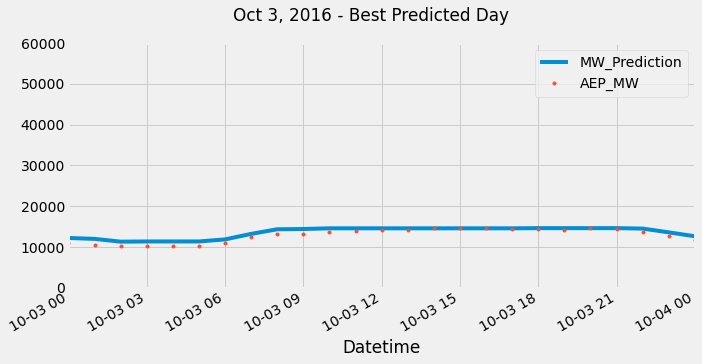

In [37]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

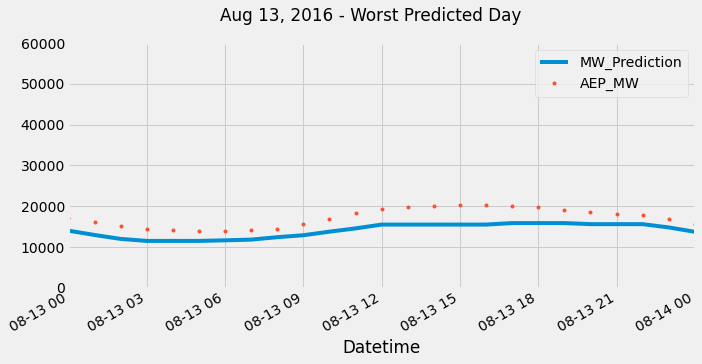

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')